In [1]:
from transformers import LlavaForConditionalGeneration, AutoProcessor
import torch
from peft import peft_model,PeftModel



In [2]:
raw_model_name_or_path = "output_model_lora_merge_001"
# peft_model_name_or_path = "output_model_lora"
model = LlavaForConditionalGeneration.from_pretrained(raw_model_name_or_path,device_map="cuda:0", torch_dtype=torch.bfloat16)
# model = PeftModel.from_pretrained(model, peft_model_name_or_path, adapter_name="peft_v1")
processor = AutoProcessor.from_pretrained(raw_model_name_or_path)
model.eval()
print('ok')

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


ok


In [3]:
from train_llava.data import LlavaDataset

llavadataset = LlavaDataset("data/liuhaotian/LLaVA-CC3M-Pretrain-595K")
len(llavadataset), llavadataset[10]

(595375,
 ('<image>\nProvide a brief description of the given image.',
  'organization is synonymous with azaleas .',
  PosixPath('data/liuhaotian/LLaVA-CC3M-Pretrain-595K/images_dl/GCC_train_000177248.jpg')))

In [4]:
testdata = llavadataset[1302]
testdata

('<image>\nRelay a brief, clear account of the picture shown.',
 'large kitchen island with an overhang and dining space next to it',
 PosixPath('data/liuhaotian/LLaVA-CC3M-Pretrain-595K/images_dl/GCC_train_001899387.jpg'))

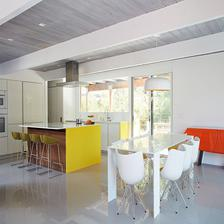

In [5]:
from PIL import Image
Image.open(testdata[2])

In [6]:
def build_model_input(model, processor, testdata:tuple):
    messages = [
        {"role": "system", "content": "You are a helpful assistant."},
        {"role": "user", "content": testdata[0]},
    ]
    prompt = processor.tokenizer.apply_chat_template(
        messages, tokenize=False, add_generation_prompt=True
    )
    # print(prompt)
    # print("*"*20)
    image = Image.open(testdata[2])
    inputs = processor(text=prompt, images=image, return_tensors="pt")
    
    for tk in inputs.keys():
        inputs[tk] = inputs[tk].to(model.device)
    generate_ids = model.generate(**inputs, max_new_tokens=20)
    
    generate_ids = [
        oid[len(iids):] for oid, iids in zip(generate_ids, inputs.input_ids)
    ]

    

    gen_text = processor.batch_decode(generate_ids, skip_special_tokens=False, clean_up_tokenization_spaces=False)[0]
    return gen_text



build_model_input(model, processor, testdata)

Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


'the kitchen is a bright yellow with a glass top island and a large window that looks out to the'